# Parallel Bayes Nets mapper

## Bayes Net to Factor Graph

In [54]:
import pyAgrum.lib.mrf2graph as m2g
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
bn=gum.loadBN("res/earthquake.bif")

In [55]:
mn=gum.MarkovRandomField.fromBN(bn)

gnb.flow.row(bn,
               gnb.getMRF(mn,view="factorgraph",size="5"),
               captions=['a Bayesian network',
                         'Factor graph'])

In [58]:
print(f"nodes       : {mn.nodes()}")
print(f"node names  : {mn.names()}")
print(f"edges       : {mn.edges()}")
print(f"components  : {mn.connectedComponents()}")
print(f"factors     : {mn.factors()}")
gnb.sideBySide(gnb.getJunctionTree(bn))
#for factor in mn.factors():
#    print(f"factor({factor}) : {mn.factor(factor)}")

nodes       : {0, 1, 2, 3, 4}
node names  : {'Alarm', 'Burglary', 'Earthquake', 'JohnCalls', 'MaryCalls'}
edges       : {(0, 1), (2, 4), (1, 2), (2, 3), (0, 2)}
components  : {0: {0, 1, 2, 3, 4}}
factors     : [{1}, {0, 1, 2}, {2, 3}, {0}, {2, 4}]


### coloring algorithm

In [71]:
class Graph:
    def __init__(self, V):
        self.V = V
        self.adj = [[] for i in range(V)]
 
    def addEdge(self, u, v):
        if not (v in self.adj[u]):
            self.adj[u].append(v)
        if not (u in self.adj[v]):    
            self.adj[v].append(u)
 
    def getMaxDegreeVertex(self, available):
        maxDegree = -1
        maxDegreeVertex = -1
        for i in range(self.V):
            if i in available and len(self.adj[i]) > maxDegree:
                maxDegree = len(self.adj[i])
                maxDegreeVertex = i
        return maxDegreeVertex
 
    def getSaturationDegree(self, vertex, color):
        saturationDegree = 0
        for i in self.adj[vertex]:
            if self.color[i] == color:
                saturationDegree += 1
        return saturationDegree
 
    def getAvailableColors(self, vertex):
        available = set(range(self.V))
        for i in self.adj[vertex]:
            if self.color[i] in available:
                available.remove(self.color[i])
        return available
 
    def dsatur(self):
        self.color = [-1] * self.V
        available = set(range(self.V))
        maxDegreeVertex = self.getMaxDegreeVertex(available)
        print(maxDegreeVertex)
        self.color[maxDegreeVertex] = 0
        available.remove(maxDegreeVertex)
        for i in range(self.V - 1):
            maxSaturationDegree = -1
            maxSaturationDegreeVertex = -1
            for j in available:
                saturationDegree = self.getSaturationDegree(j, self.color[j])
                if saturationDegree > maxSaturationDegree:
                    maxSaturationDegree = saturationDegree
                    maxSaturationDegreeVertex = j
            if maxSaturationDegreeVertex == -1:
                maxDegreeVertex = self.getMaxDegreeVertex(available)
                self.color[maxDegreeVertex] = 0
                available.remove(maxDegreeVertex)
            else:
                availableColors = self.getAvailableColors(maxSaturationDegreeVertex)
                self.color[maxSaturationDegreeVertex] = min(availableColors)
                available.remove(maxSaturationDegreeVertex)
        return self.color

In [8]:
def mn_color(mn):
    g = Graph(len(mn.nodes()))
    for edge in mn.edges():
        g.addEdge(edge[0], edge[1])
    # Assign colors using the DSatur algorithm
    colors = g.dsatur()

    # Print the color assignment for each vertex
    #for i in range(g.V):
    #    print("Vertex", i, "is assigned color", colors[i])   
    return colors

In [9]:
a = list(mn.nodes())
len(a)

5

In [10]:

colors = mn_color(mn)
#colors = [1, 1, 1, 1, 0]

norm_colors = [float(i)/sum(colors) for i in colors]

nodeColor = {}
nodeColor = {mn.variable(i).name(): norm_colors[i] for i in range(len(norm_colors))}


2


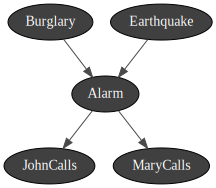

In [63]:
gnb.showBN(bn, nodeColor=nodeColor)


In [64]:
#bn=gum.loadBN("./bif/water.bif")
mn=gum.MarkovRandomField.fromBN(bn)
colors = mn_color(mn)
norm_colors = [float(i)/max(colors) for i in colors]

nodeColor = {}
nodeColor = {mn.variable(i).name(): norm_colors[i] for i in range(len(norm_colors))}
nodeColor

2


{'Burglary': 0.5,
 'Earthquake': 1.0,
 'Alarm': 0.0,
 'JohnCalls': 0.5,
 'MaryCalls': 0.5}

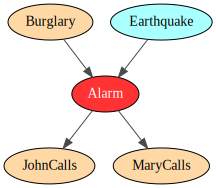

In [65]:
gnb.showBN(bn, nodeColor=nodeColor)


In [ ]:
#return all the name of the current Markov Blanket
def neighborList(mn, nodeName):
    neighborlist = []
    nodeID = mn.idFromName(nodeName)
    for factor in mn.factors():
        if nodeID in factor:
            for item in factor:
                if item != nodeID:
                    neighborlist.append(mn.variable(item).name())

    return neighborlist

In [87]:
def graphmapping_method1(nodeColor, coreNum):
    GraphMapped = {}
    index = 0
    keys = []
    values = []
    for SingleColor in norm_colors:
        index = 0
        for k, v in nodeColor.items():
            if v == SingleColor:
                keys.append (k)
                values.append({"color": SingleColor, "processor": index%coreNum}) 
                index += 1

    GraphMapped = dict(zip(keys, values))
    return GraphMapped

In [126]:

c = Counter([1,1,2,2,2,3,0])
for k, v in c.most_common():
    print(k, v)

2 3
1 2
3 1
0 1


In [ ]:
import Counter
#'Burglary': {'color': 0.5, 'processor': 0}
def graphmapping_method2(mn, nodeColor, coreNum):
    GraphMapped = {}
    index = 0
    keys = []
    values = []
    for SingleColor in norm_colors:
        index = 0
        assignCoreList = []
        for k, v in nodeColor.items():
            if v == SingleColor:
                keys.append (k)
                #find Markov Blanket and search for the max. likehood of processor
                nodesMB = neighborList(mn, k)
                #get all the neighbor's assignments
                coreNumMB = []
                for nodeMB in nodesMB:
                    if nodeMB in GraphMapped.keys():
                        coreNumMB.append(GraphMapped[nodeMB]['processor'])
                #order the assignments and find the most likelihood possible
                c = Counter(coreNumMB)
                currentAssign = -1
                for keyCoreMB, valueCoreMB in c.most_common():
                    #reduce the overlap to max the throught
                    assignCount = Counter(assignCoreList).most_common()[0]
                    if keyCoreMB != assignCount:
                        currentAssign = keyCoreMB
                        assignCoreList.append(currentAssign) 

                values.append({"color": SingleColor, "processor": index%coreNum}) 
                index += 1

    GraphMapped = dict(zip(keys, values))
    return GraphMapped

### Modeling

In [110]:
#computing memory footpring
import numpy as np
def sampleCost(mn, nodeName, graph_mapped, coreNum=16):
    nodeMB = neighborList(mn, nodeName)
    processID = graph_mapped[nodeName]['processor']
    coordsNode = [np.floor(processID/np.sqrt(coreNum)), processID%np.sqrt(coreNum)]
    distance = 0
    for neighNodes in nodeMB:
        processID = graph_mapped[neighNodes]['processor']
        coordNeigh = [np.floor(processID/np.sqrt(coreNum)), processID%np.sqrt(coreNum)]
        distance += abs(coordNeigh[0] - coordsNode[0]) + abs(coordNeigh[1] - coordsNode[1])

    return distance

In [121]:
def memCost(mn, graph_mapped):
    totalDis = 0
    for k, v in graph_mapped.items():
        totalDis += sampleCost(mn, k, graph_mapped)
    return totalDis

In [ ]:
def timeCost(mn, graph_mapped):
    

In [123]:
from collections import Counter
import matplotlib.pyplot as plt

files = ["asia", "water", "hailfinder", "diabetes", "munin"]
nodes = [8, 32, 56, 413, 1041]
path = "./bif/"
for i, file in enumerate(files):
    local_path = path + file +".bif"
    bn=gum.loadBN(local_path)
    mn=gum.MarkovRandomField.fromBN(bn)
    colors = mn_color(mn)
    norm_colors = [float(i)/max(colors) for i in colors]
    nodeColor = {}
    nodeColor = {mn.variable(i).name(): norm_colors[i] for i in range(len(norm_colors))}

    #mapping
    graph_mapped = graphmapping_method1(nodeColor, 16)

    #memory footprint
    totalMem = memCost(mn, graph_mapped)


5
10
26
1
8


In [118]:
graph_mapped = graphmapping_method1(nodeColor, 4)

print(graph_mapped)

cpt = bn.cpt(bn.idFromName('Alarm'))
totalMem = memCost(mn, graph_mapped)

print(f"range size      : {cpt.shape[0]}")
print(f"parents         : {len(cpt.shape)-1}")
print(f"CPT table size  : {cpt.domainSize()}")
print(f"Node ID         : {bn.idFromName('Alarm')}")
print(cpt)

print(neighborList(mn, "MaryCalls"))
print(f"memory move distance : {totalMem}")


{'Burglary': {'color': 0.5, 'processor': 0}, 'JohnCalls': {'color': 0.5, 'processor': 1}, 'MaryCalls': {'color': 0.5, 'processor': 2}, 'Earthquake': {'color': 1.0, 'processor': 0}, 'Alarm': {'color': 0.0, 'processor': 0}}
range size      : 2
parents         : 2
CPT table size  : 8
Node ID         : 2

             ||  Alarm            |
Burgla|Earthq||True     |False    |
------|------||---------|---------|
True  |True  || 0.9500  | 0.0500  |
False |True  || 0.2900  | 0.7100  |
True  |False || 0.9400  | 0.0600  |
False |False || 0.0010  | 0.9990  |

['Alarm']
memory move distance : 6.0


In [120]:
import numpy as np
coreNum = 16

alpha = 5

coreRuntime = np.zeros(coreNum)
totalRuntime = 0
for key, value in graph_mapped.items():
    cpt = bn.cpt(bn.idFromName(key))
    RangeSize = cpt.shape[0]
    coreRuntime[value["processor"]] += RangeSize * alpha
    if(value["color"] != previous_value[]):

coreRuntime    
    

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1802661367.py, line 12)

## nodes mapping
using the heuristic algorithms to balance the workload

Counter({0: 3, 1: 3, 2: 2})
0
Counter({0: 9, 1: 5, 4: 5, 2: 5, 3: 5, 5: 3})
1
Counter({1: 24, 0: 13, 2: 11, 3: 6, 4: 2})
2
Counter({1: 144, 2: 134, 0: 98, 3: 37})
3
Counter({1: 378, 0: 285, 2: 263, 3: 95, 4: 20})
4


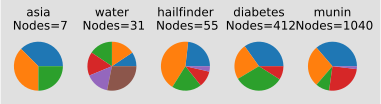

In [ ]:
import pandas
from collections import Counter
import matplotlib.pyplot as plt

files = ["asia", "water", "hailfinder", "diabetes", "munin"]
nodes = [8, 32, 56, 413, 1041]
path = "./bif/"
fig, axs = plt.subplots(1, 5)
for i, file in enumerate(files):
    local_path = path + file +".bif"
    bn=gum.loadBN(local_path)
    mn=gum.MarkovRandomField.fromBN(bn)
    colors = mn_color(mn)
    letter_counts = Counter(colors)
    runtime=letter_counts.most_common(1)[0][1]
    print(letter_counts)
    items = list(letter_counts.keys())
    counts = list(letter_counts.values())
    print(i)
    axs[i].pie([float(v) for v in counts], autopct=None)
    title = file+"\n Nodes="+str(list(bn.nodes())[-1])
    axs[i].set_title(title)